In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import dataloader, dataset

from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer
from transformers import Trainer, TrainingArguments, BertForSequenceClassification


from sklearn.metrics import f1_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')

c:\Users\mikew\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder = LabelEncoder()

In [3]:
# dataset process
df = pd.read_csv("./datasets/dataset.csv")
input_txt = df['Sentence'].tolist()
labels = df['label'].tolist()
print(len(labels))
train_txt, val_txt, train_l_txt, val_l_txt = train_test_split(
    input_txt, labels, test_size=0.2, random_state=42
)
train_len = len(train_txt)
print(train_len)
val_len = len(val_txt)
print(val_len)

20678
16542
4136


In [4]:
train_inputs = tokenizer(train_txt, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
valid_inputs = tokenizer(val_txt, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

train_labels = label_encoder.fit_transform(train_l_txt)
train_labels = torch.tensor(train_labels)
val_labels = label_encoder.fit_transform(val_l_txt)
val_labels = torch.tensor(val_labels)


In [5]:
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"Original: {original} -> Encoded: {encoded}")

Original: apple -> Encoded: 0
Original: calculator -> Encoded: 1
Original: candle -> Encoded: 2
Original: coffee capsules -> Encoded: 3
Original: cream cheese -> Encoded: 4
Original: light bulb -> Encoded: 5
Original: milk -> Encoded: 6
Original: pumpkin -> Encoded: 7
Original: slippers -> Encoded: 8
Original: toothpaste -> Encoded: 9


In [6]:
labels = ['apple', 'calculator', 'candle', 'coffee', 'cream cheese', 'light bulb', 'milk', 'pumpkin', 'slippers', 'toothpaste']

In [7]:
print(len(train_inputs['input_ids']))
# print(valid_inputs)
print(len(set(train_labels)))
print(train_labels)

16542
16542
tensor([3, 5, 9,  ..., 2, 2, 7])


In [8]:
for key, val in enumerate(train_inputs):
    print(f"key is: {val}, value is {train_inputs[val]}")

key is: input_ids, value is tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2064, 1045,  ...,    0,    0,    0],
        [ 101, 2079, 2017,  ...,    0,    0,    0],
        ...,
        [ 101, 2064, 1045,  ...,    0,    0,    0],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0]])
key is: token_type_ids, value is tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
key is: attention_mask, value is tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [9]:
class BertDataSet(dataset.Dataset):
    def __init__(self, encodings, length, labels = None, is_test = False):
        self.is_test = is_test
        self.length = length
        if self.is_test:
            self.encodings = encodings
        else: 
            self.encodings = encodings
            self.labels = labels
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        '''item: dict('input_ids', 'attention_mask', 'token_type_ids', 'labels')'''
        item = {}
        for key, val in enumerate(self.encodings):
            item[val] = torch.tensor(self.encodings[val][idx])
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings}
        if self.is_test == False:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    

In [10]:
train_dataset = BertDataSet(train_inputs, length=train_len, labels=train_labels)
valid_dataset = BertDataSet(valid_inputs, length=val_len, labels=val_labels)



In [11]:
for data in train_dataset:
    print(data)
    break

{'input_ids': tensor([  101,  2073,  2003,  1996,  4157, 18269,  2015,  2930,  1029,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The devices using is : {device}")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10).to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
LR  = 1e-7
batch_size = 64


epochs = 10
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2)

The devices using is : cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
train_dataloader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = dataloader.DataLoader(valid_dataset, batch_size=batch_size)



In [14]:
for data in train_dataloader:
    print(data)
    break

{'input_ids': tensor([[ 101, 2064, 1045,  ...,    0,    0,    0],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        [ 101, 1045, 2342,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 1521,  ...,    0,    0,    0],
        [ 101, 2003, 2422,  ...,    0,    0,    0],
        [ 101, 2064, 1045,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([6, 0, 5, 1, 3, 2, 5, 4, 2, 5, 0, 8, 9, 1, 4, 1, 4, 8, 4, 6, 2, 0, 0, 5,
        7, 3, 4, 9, 6, 6, 4, 4, 7, 2, 9, 5, 7, 4, 7, 3, 0, 3, 0, 9, 2, 4, 1, 7,
        6, 6, 0

In [15]:
# training
train_loss_plot = []
val_loss_plot = []
train_acc_plot = []
val_acc_plot = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    correct = 0
    total = 0

    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    for batch in tqdm(train_dataloader):
        losses = []
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():

            batch_ids = batch["input_ids"].to(device, non_blocking = True)
            batch_mask = batch["attention_mask"].to(device, non_blocking = True)

            output = model(batch_ids, batch_mask) 
            output = output['logits'].squeeze(-1).to(torch.float32)
            

            output_probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output_probs, 1)
            
            # print(output_probs.shape)

            batch_labels = batch['labels'].to(device, non_blocking = True) 
            # print(f"output is: {output.shape}, labels are: {batch_labels}")
            

            loss = loss_fn(output, batch_labels)
            losses.append(loss.item())
            # preds = torch.max(output_probs)
            # print(output_probs)
        
            # correct_predictions += torch.sum(preds == batch_labels)
        loss.backward()
        optimizer.step()
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
            

    avg_train_loss = np.mean(losses)
    training_accuracy = correct / total
    # correctness = correct_predictions.detach().cpu().numpy()
    # train_accuracy = correctness/(len(train_labels))
    train_loss_plot.append(avg_train_loss)
    train_acc_plot.append(training_accuracy)
    print(f"Training loss: {avg_train_loss}, Training accuracy: {training_accuracy}")


    # validation
    model.eval()
    correct_val = 0
    total_val = 0
    all_output_probs = []

    for batch in tqdm(valid_dataloader):
        losses = []
        batch_ids = batch["input_ids"].to(device, non_blocking = True)
        batch_mask = batch["attention_mask"].to(device, non_blocking = True)
        with torch.no_grad():
            output = model(batch_ids, batch_mask)
        
        output = output['logits'].squeeze(-1).to(torch.float32)
        
        output_probs = torch.softmax(output, dim=1)

        # preds = torch.max(output_probs)
        _, predicted = torch.max(output_probs, 1)

        batch_labels = batch['labels'].to(device, non_blocking = True) 

        loss = loss_fn(output_probs, batch_labels)
        losses.append(loss.item())

        # all_output_probs.extend(output_probs.detach().cpu().numpy())
        total_val += batch_labels.size(0)
        correct_val += (predicted == batch_labels).sum().item()
        # correct_predictions += torch.sum(preds == batch_labels)
    
    avg_val_loss = np.mean(losses)
    val_accuracy = correct_val / total_val
    # correctness = correct_predictions.detach().cpu().numpy()
    # val_accuracy = correctness/(len(train_labels))



    # accuracy = accuracy_score(labels, preds)
    val_loss_plot.append(avg_val_loss)
    val_acc_plot.append(val_accuracy)
    print(f"validation loss: {avg_val_loss}, validation accuracy: {val_accuracy}")

            

Epoch 1/10


100%|██████████| 259/259 [01:39<00:00,  2.61it/s]


Training loss: 2.2595863342285156, Training accuracy: 0.1147986942328618


100%|██████████| 65/65 [02:45<00:00,  2.55s/it]


validation loss: 2.297741413116455, validation accuracy: 0.13201160541586074
Epoch 2/10


100%|██████████| 259/259 [02:24<00:00,  1.79it/s]


Training loss: 2.2325892448425293, Training accuracy: 0.14006770644420263


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 2.290881395339966, validation accuracy: 0.17190522243713732
Epoch 3/10


100%|██████████| 259/259 [02:36<00:00,  1.66it/s]


Training loss: 2.220965623855591, Training accuracy: 0.1765203723854431


100%|██████████| 65/65 [02:50<00:00,  2.62s/it]


validation loss: 2.278289318084717, validation accuracy: 0.23065764023210833
Epoch 4/10


100%|██████████| 259/259 [02:24<00:00,  1.79it/s]


Training loss: 2.0936663150787354, Training accuracy: 0.22143634385201305


100%|██████████| 65/65 [02:50<00:00,  2.62s/it]


validation loss: 2.26835560798645, validation accuracy: 0.26499032882011603
Epoch 5/10


100%|██████████| 259/259 [02:27<00:00,  1.76it/s]


Training loss: 1.9457128047943115, Training accuracy: 0.27626647321968323


100%|██████████| 65/65 [02:49<00:00,  2.61s/it]


validation loss: 2.257899284362793, validation accuracy: 0.3498549323017408
Epoch 6/10


100%|██████████| 259/259 [02:32<00:00,  1.69it/s]


Training loss: 1.9376276731491089, Training accuracy: 0.33067343731108695


100%|██████████| 65/65 [02:50<00:00,  2.62s/it]


validation loss: 2.2481296062469482, validation accuracy: 0.4480174081237911
Epoch 7/10


100%|██████████| 259/259 [02:26<00:00,  1.77it/s]


Training loss: 1.8148350715637207, Training accuracy: 0.4037601257405392


100%|██████████| 65/65 [02:49<00:00,  2.61s/it]


validation loss: 2.2377045154571533, validation accuracy: 0.565522243713733
Epoch 8/10


100%|██████████| 259/259 [02:24<00:00,  1.79it/s]


Training loss: 1.7930870056152344, Training accuracy: 0.48416152823116915


100%|██████████| 65/65 [02:49<00:00,  2.61s/it]


validation loss: 2.2269089221954346, validation accuracy: 0.6460348162475822
Epoch 9/10


100%|██████████| 259/259 [02:28<00:00,  1.74it/s]


Training loss: 1.7703337669372559, Training accuracy: 0.5678273485672832


100%|██████████| 65/65 [02:49<00:00,  2.61s/it]


validation loss: 2.2127180099487305, validation accuracy: 0.7521760154738878
Epoch 10/10


100%|██████████| 259/259 [02:32<00:00,  1.70it/s]


Training loss: 1.6747595071792603, Training accuracy: 0.6317253052835208


100%|██████████| 65/65 [02:49<00:00,  2.61s/it]

validation loss: 2.1956779956817627, validation accuracy: 0.8213249516441006


In [23]:
# save model
torch.save(model.state_dict(), 'Bert_state.pth')

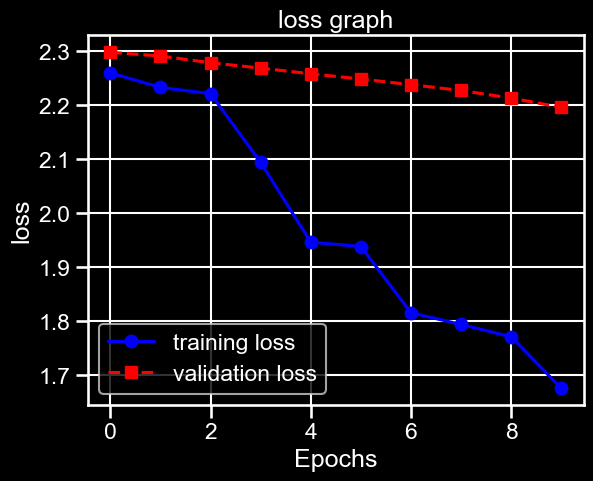

In [17]:
# visualize loss and accuracy

 

plt.plot(train_loss_plot, label='training loss', color='blue', marker='o')  # First line
plt.plot(val_loss_plot, label='validation loss', color='red', linestyle='--', marker='s')  # Second line

# Adding details
plt.title("loss graph")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()  # Add legend to distinguish lines
plt.grid(True)
plt.show()

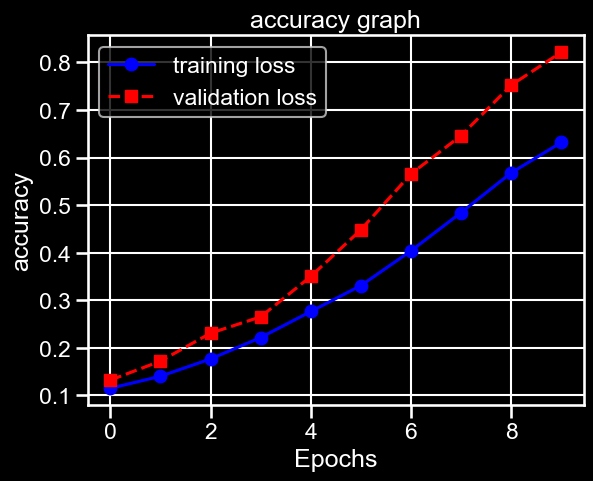

In [18]:

plt.plot(train_acc_plot, label='training loss', color='blue', marker='o')  # First line
plt.plot(val_acc_plot, label='validation loss', color='red', linestyle='--', marker='s')  # Second line

# Adding details
plt.title("accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()  # Add legend to distinguish lines
plt.grid(True)
plt.show()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The devices using is : {device}")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10).to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
LR  = 1e-5
batch_size = 64


epochs = 10
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2)

The devices using is : cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
train_loss_plot = []
val_loss_plot = []
train_acc_plot = []
val_acc_plot = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    correct = 0
    total = 0

    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    for batch in tqdm(train_dataloader):
        losses = []
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():

            batch_ids = batch["input_ids"].to(device, non_blocking = True)
            batch_mask = batch["attention_mask"].to(device, non_blocking = True)

            output = model(batch_ids, batch_mask) 
            output = output['logits'].squeeze(-1).to(torch.float32)
            

            output_probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output_probs, 1)
            
            # print(output_probs.shape)

            batch_labels = batch['labels'].to(device, non_blocking = True) 
            # print(f"output is: {output.shape}, labels are: {batch_labels}")
            

            loss = loss_fn(output, batch_labels)
            losses.append(loss.item())
            # preds = torch.max(output_probs)
            # print(output_probs)
        
            # correct_predictions += torch.sum(preds == batch_labels)
        loss.backward()
        optimizer.step()
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
            

    avg_train_loss = np.mean(losses)
    training_accuracy = correct / total
    # correctness = correct_predictions.detach().cpu().numpy()
    # train_accuracy = correctness/(len(train_labels))
    train_loss_plot.append(avg_train_loss)
    train_acc_plot.append(training_accuracy)
    print(f"Training loss: {avg_train_loss}, Training accuracy: {training_accuracy}")


    # validation
    model.eval()
    correct_val = 0
    total_val = 0
    all_output_probs = []

    for batch in tqdm(valid_dataloader):
        losses = []
        batch_ids = batch["input_ids"].to(device, non_blocking = True)
        batch_mask = batch["attention_mask"].to(device, non_blocking = True)
        with torch.no_grad():
            output = model(batch_ids, batch_mask)
        
        output = output['logits'].squeeze(-1).to(torch.float32)
        
        output_probs = torch.softmax(output, dim=1)

        # preds = torch.max(output_probs)
        _, predicted = torch.max(output_probs, 1)

        batch_labels = batch['labels'].to(device, non_blocking = True) 

        loss = loss_fn(output_probs, batch_labels)
        losses.append(loss.item())

        # all_output_probs.extend(output_probs.detach().cpu().numpy())
        total_val += batch_labels.size(0)
        correct_val += (predicted == batch_labels).sum().item()
        # correct_predictions += torch.sum(preds == batch_labels)
    
    avg_val_loss = np.mean(losses)
    val_accuracy = correct_val / total_val
    # correctness = correct_predictions.detach().cpu().numpy()
    # val_accuracy = correctness/(len(train_labels))



    # accuracy = accuracy_score(labels, preds)
    val_loss_plot.append(avg_val_loss)
    val_acc_plot.append(val_accuracy)
    print(f"validation loss: {avg_val_loss}, validation accuracy: {val_accuracy}")

Epoch 1/10


100%|██████████| 259/259 [02:25<00:00,  1.79it/s]


Training loss: 0.09066545963287354, Training accuracy: 0.9090194656027083


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 1.5152478218078613, validation accuracy: 1.0
Epoch 2/10


100%|██████████| 259/259 [02:27<00:00,  1.76it/s]


Training loss: 0.029744569212198257, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 1.4782943725585938, validation accuracy: 1.0
Epoch 3/10


100%|██████████| 259/259 [02:31<00:00,  1.71it/s]


Training loss: 0.015053045935928822, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 1.4701683521270752, validation accuracy: 1.0
Epoch 4/10


100%|██████████| 259/259 [02:34<00:00,  1.67it/s]


Training loss: 0.010150179266929626, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 1.4668704271316528, validation accuracy: 1.0
Epoch 5/10


100%|██████████| 259/259 [02:25<00:00,  1.78it/s]


Training loss: 0.007110774517059326, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.64s/it]


validation loss: 1.4651378393173218, validation accuracy: 1.0
Epoch 6/10


100%|██████████| 259/259 [02:26<00:00,  1.76it/s]


Training loss: 0.004929342772811651, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.63s/it]


validation loss: 1.4641039371490479, validation accuracy: 1.0
Epoch 7/10


100%|██████████| 259/259 [02:31<00:00,  1.71it/s]


Training loss: 0.0037347511388361454, Training accuracy: 1.0


100%|██████████| 65/65 [02:51<00:00,  2.64s/it]


validation loss: 1.4634238481521606, validation accuracy: 1.0
Epoch 8/10


100%|██████████| 259/259 [02:29<00:00,  1.73it/s]


Training loss: 0.0031612208113074303, Training accuracy: 1.0


100%|██████████| 65/65 [02:52<00:00,  2.66s/it]


validation loss: 1.4629478454589844, validation accuracy: 1.0
Epoch 9/10


100%|██████████| 259/259 [02:34<00:00,  1.67it/s]


Training loss: 0.002528454875573516, Training accuracy: 1.0


100%|██████████| 65/65 [02:50<00:00,  2.63s/it]


validation loss: 1.4626054763793945, validation accuracy: 1.0
Epoch 10/10


100%|██████████| 259/259 [02:29<00:00,  1.73it/s]


Training loss: 0.0021529989317059517, Training accuracy: 1.0


100%|██████████| 65/65 [02:53<00:00,  2.67s/it]

validation loss: 1.462345838546753, validation accuracy: 1.0


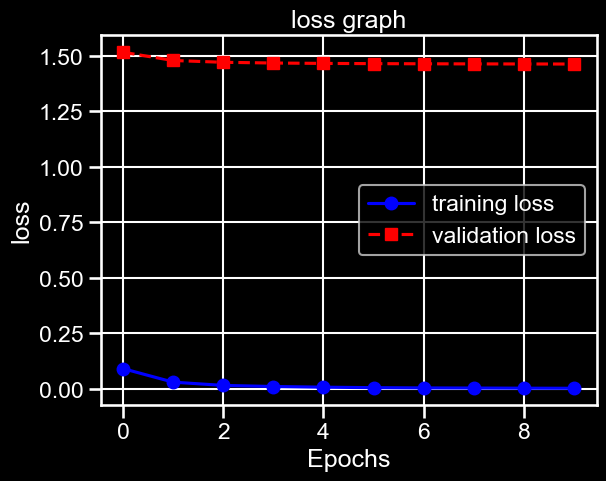

In [21]:

plt.plot(train_loss_plot, label='training loss', color='blue', marker='o')  # First line
plt.plot(val_loss_plot, label='validation loss', color='red', linestyle='--', marker='s')  # Second line

# Adding details
plt.title("loss graph")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()  # Add legend to distinguish lines
plt.grid(True)
plt.show()

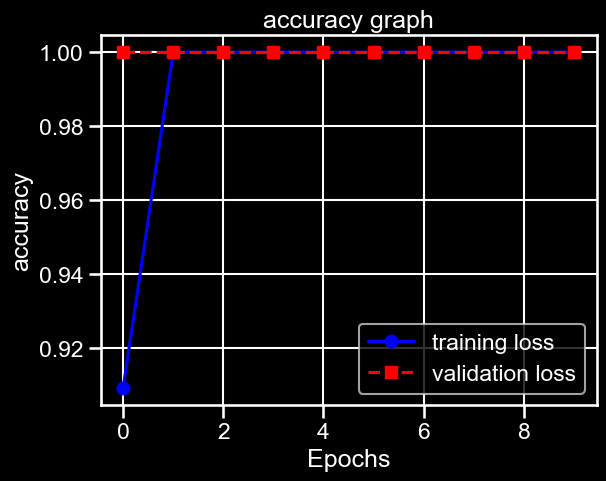

In [22]:
plt.plot(train_acc_plot, label='training loss', color='blue', marker='o')  # First line
plt.plot(val_acc_plot, label='validation loss', color='red', linestyle='--', marker='s')  # Second line

# Adding details
plt.title("accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()  # Add legend to distinguish lines
plt.grid(True)
plt.show()

### Test trained model

In [24]:
# load model: 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

# Load the state dictionary
state_dict = torch.load('Bert_state.pth')

# Load the weights into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode (if you're using it for inference)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
# process the input dataset
words = pd.read_csv('./datasets/test_words.txt', header=None, names=['sentences'])
test_txt = words['sentences'].tolist()
# for text in input_txt:
#     print(text)
test_len = len(test_txt)
test_tokens = tokenizer(test_txt, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
# print(len(test_tokens['input_ids']))
test_dataset = BertDataSet(test_tokens,length=test_len, is_test=True)
test_dataloader = dataloader.DataLoader(test_dataset, batch_size=1, shuffle=False)

# print(len(test_dataloader))
    # break
    
# print(test_input)

In [26]:
correct_val = 0
total_val = 0
all_output_probs = []
output_dir = './output/output.txt'
with open (output_dir, 'w') as f:
    for batch in test_dataloader:
        losses = []
        batch_ids = batch["input_ids"]
        batch_mask = batch["attention_mask"]
        with torch.no_grad():
            output = model(batch_ids, batch_mask)
        
        output = output['logits'].squeeze(-1).to(torch.float32)
        
        output_probs = torch.softmax(output, dim=1)

        # preds = torch.max(output_probs)
        _, predicted = torch.max(output_probs, 1)
        f.write(f"{labels[predicted.item()]}\n")